# Machine learning with graphs

## Assignment 6 (21/04/2021)

Notebook for Homeworks proposed in the MLG in the seminar of 2021 based on Machine learning with graphs course by Standford university.


In [1]:
#Importing generic libraries.
import numpy as np
import pandas as pd
import scipy 

# Graph related libraries 
import networkx as nx

# Util libraries
from collections import Counter, OrderedDict
import itertools
import random

#Plotting library
import matplotlib.pyplot as plt
import copy

## 1 Node Classification

### 1.1 Relational Classification

As we discussed in class, we can use relational classification to predict node labels. Consider the graph G as shown in Figure 1. We would like to classify nodes into 2 classes "+" and "-". Labels for node 3, 5, 8 and 10 are given (red for "+", blue for "-"). Recall that using a probabilistic relational classifier to predict label $Y_i$ for node $i$ is defined as:

$$P(Y_i = c) = \frac{1}{\vert N_i \vert} \sum_{(i,j)\in E}W(i,j)P(Y_j=c)$$

where $\vert N_i \vert$ is the number of neighbors of node $i$. Assume all the edges have edge weight $W(i, j) = 1$ in this graph. For labeled nodes, initialize with the ground-truth $Y$ labels, i.e., $P(Y_3 = +) = P(Y_5 = +) = 1.0$; $P(Y_8 = +) = P(Y_{10} = +) = 0$. For unlabeled nodes, use unbiased initialization $P(Y_i = +) = 0.5$. Update nodes by node ID in ascending order (i.e., update node 1 first, then node 2, etc.)

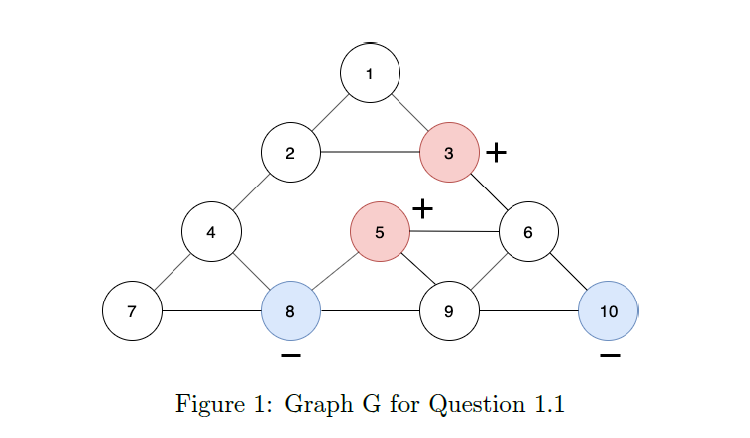

In [ ]:
G = nx.Graph()
G.add_nodes_from(list(range(1,11)))
G.add_edges_from([(1, 2), (1, 3),
                  (2, 3), (2, 4),
                  (3, 6),
                  (4, 7), (4, 8),
                  (5, 6), (5, 8), (5, 9),
                  (6, 9), (6, 10),
                  (7, 8),
                  (8, 9),
                  (9, 10)
                 ])

G.add_nodes_from([3,5], P_positive = 1)
G.add_nodes_from([8,10], P_positive = 0)

nx.draw(G,with_labels=True)
G.nodes.data()

In [ ]:
for node in G.nodes():
    try:
        G.nodes[node]['P_positive']
    except:
        G.nodes[node]['P_positive'] = 0.5
G.nodes.data() 

(i) After the second iteration, give $P(Y_i = +)$ for $i = 2, 4, 6$.

(ii) If we use 0.5 as the probability threshold, i.e., consider a node $i$ belonging to class "+" if $P(Y_i = +) > 0.5$, which node will belong to class "+" in the end? Which will belong to class "-"?

### 1.2 Belief Propagation

In this problem, we will be using Belief Propagation(BP) on Conditional Random Field to solve inference problems.

Conditional Random Fields (CRF) are an important special case of Markov Random Fields to model conditional probability distribution. They define a probability distribution p over variables $x_1,\ x_2, \ldots,\ x_n$ and observations $y_1,\ y_2, \ldots,\ y_m$, which in turn elicit an undirected graph G. The distribution has the form:

$$p(x_1,\ x_2, \ldots,\ x_n|y_1,\ y_2, \ldots,\ y_m) = \frac{1}{Z} \prod_{c\in C}\phi_c(x_c,y_c)$$

where $C$ denotes the set of cliques (i.e., fully connected subgraphs) of G, each factor $\phi_c$ is a nonegative function over the variables in a clique, and $Z$ denotes the normalizing constant that ensures the distribution $p$ sums to 1.

For the example (Figure 2) below, the filled-in circles represent the observed nodes $y_i$ and the empty circles represent the variables $x_i$. A clique in this graph is just a pair of two connected nodes, and then we have $p(x_1,\ x_2, \ldots,\ x_n|y_1,\ y_2, \ldots,\ y_n) = \frac{1}{Z} \prod_{i=2}^n \phi_{i-1,i}(x_{i-1},x_i)\prod_{j=1}^n \phi_{j}(x_{i},y_j)$, where $\phi_{j}(x_{i},y_j)$ describes some statistical dependency between $x_j$ and $y_j$ at each position $j$, and $\phi_{i-1,i}(x_{i-1},x_i)$ describes compatibility between the nearby variables $x_{i-1}$ and $x_i$.

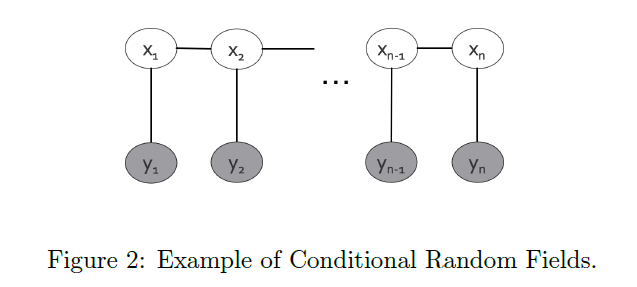

For consistency with the lecture slides, we will use $\phi_j(x_j) = \phi_j(x_j, y_j)$ since we have already observed nodes $y_j$, and use  $\psi_{ik}(x_i, x_k) = \phi_{i-1,i}(x_{i-1}, x_i)$ with $i,\ k$ adjacent. Then the above example can be written as $p(x_1,\ x_2, \ldots,\ x_n|y_1,\ y_2, \ldots,\ y_n) = \frac{1}{Z} \prod_{i,k\ \mathrm{adjacent}} \psi_{i,k}(x_i,x_k)\prod_{j=1}^n \phi_{j}(x_j)$. Note that $\psi_{ik}(x_i, x_k)=\psi_{ki}(x_i, x_k)=\psi_{ik}(x_k,x_i)=\psi_{ki}(x_k,x_i)$.

We define the following for BP as from class:



**Message** $m_{ij}(x_j)$: can be intuitively understood as a message from hidden node $x_i$ to hidden node $x_j$ about what state node $i$ thinks node $j$ should be in.

$$m_{ij}(x_j) = \sum_{x_i} \phi_i(x_i)\psi_{ij}(x_i,x_j)\prod_{k\in N_i\setminus \{j\}}m_{ki}(x_i),$$

where $N_i\setminus \{j\}$ denotes neighbors of node i except node j.

**Belief** $b_i(xi)$: $b_i(xi) = \frac{1}{Z} \phi_i(x_i)\prod_{j\in N_i}m_{ji}$ where $Z$ denotes the normalizing constant that
ensures elements in $b_i(x_i)$ sum to 1.

(i) Consider the network with four hidden nodes shown in Figure 3. Compute the belief at node
1, $b_1(x_1)$, using the belief propagation rules, and write the result in terms of $\phi$'s and $\psi$'s.

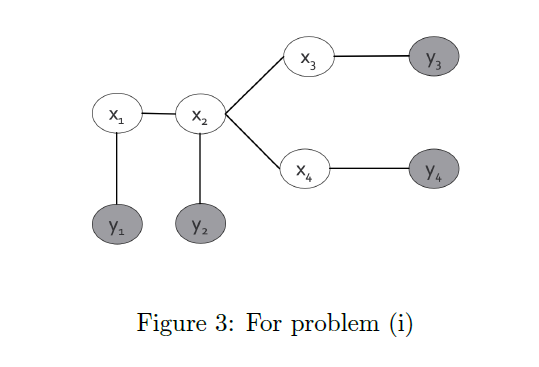

(ii) Prove that the belief at node 1 calculated above, $b_1(x_1)$, is the same as the marginal probability of $x_1$ conditioned on the observations, $p(x_1|y_1,\ y_2,\ y_3,\ y_4)$.


(iii) **Coding**. Let's work with a graph without cycles as shown in Figure 4. Assume $x$ and $y$ only have two states (0 and 1) and the graphical model has 5 hidden variables, and two variables observed with $y_2 = 0$, $y_4 = 1$. The compatibility matrices are given in the arrays below. For example, in  $\psi_{12}(x_1, x_2)$, row indices are states 0, 1 for $x_1$, and column indices are states 0, 1 for $x_2$. Remember that in this case there won't be $\phi_1(x_1)$, $\phi_3(x_3)$ $\phi_5(x_5)$ since there is no observation for them.
$\psi_{12}(x_1, x_2) = \psi_{34}(x_3, x_4) = \begin{pmatrix}
1 & 0.9\\
0.9 & 1
\end{pmatrix}$, $\psi_{23}(x_2, x_3) = \psi_{35}(x_3, x_5) = \begin{pmatrix}
0.1 & 1\\
1 & 0.1
\end{pmatrix}$, $\phi_{2}(x_2, y_2) = \phi_{4}(x_4, y_4) = \begin{pmatrix}
1 & 0.1\\
0.1 & 1
\end{pmatrix}$.

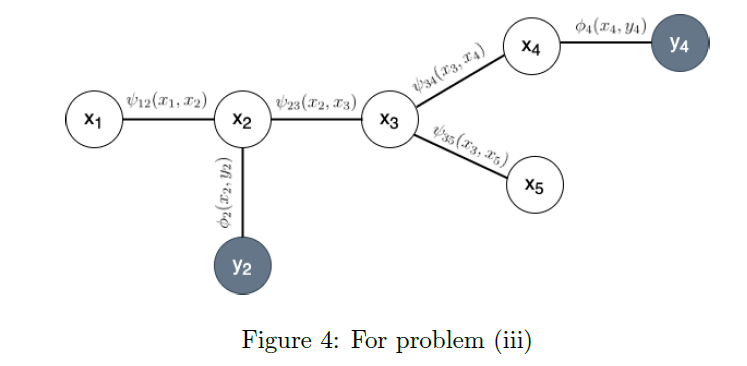

Write Python code to calculate $b_1(x_1)$, $b_2(x_2)$, $b_3(x_3)$, $b_4(x_4)$, $b_5(x_5)$ by using a library like numpy. (*You don't need to write a general BP algorithm this coding assignment should be simply based on linear algebra, e.g., matrix multiplication, to help you calculate the belief values. It should not take you more than a few lines of code with numpy*.) 

Is the prediction what you expected?